In [3]:
import pandas as pd
import numpy as np
import cv2

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
# progress bar for pandas
from tqdm.notebook import tqdm
tqdm.pandas()

### Read labels & Images

In [6]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [7]:
EPOCHS = 20
SAMPLE_LEN = 1821
IMAGE_PATH = "images/"

In [8]:
def load_image(image_id):
    file_path = image_id + ".jpg"
    image = cv2.imread(IMAGE_PATH + file_path)
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

train_images = train_data["image_id"][:SAMPLE_LEN].progress_apply(load_image)

In [10]:
test_images = test_data["image_id"][:SAMPLE_LEN].progress_apply(load_image)

#### Covert labels to label encoding

In [11]:
encoded_labels = train_data[['healthy', 'multiple_diseases', 'rust', 'scab']]
# rust = 3, scab = 4, healthy = 1, multiple_diseases = 2

In [12]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
labels = [[1],[2],[3],[4]]
encoder = enc.fit(labels)
decoded_labels = encoder.inverse_transform(encoded_labels)

### Preprocessing

#### Resizing (interpolation method, inter area)

In [13]:
# inner area
img_size = 112
ptrain_images = []
for image in train_images:
    image=cv2.resize(image,(img_size,img_size),interpolation=cv2.INTER_AREA)
    ptrain_images.append(image)

In [14]:
# inner area
ptest_images = []
for image in test_images:
    image=cv2.resize(image,(img_size,img_size),interpolation=cv2.INTER_AREA)
    ptest_images.append(image)

In [15]:
X_train = np.ndarray(shape=(len(ptrain_images), img_size*img_size*3), dtype=np.float32)
for i, image in enumerate(ptrain_images):
    X_train[i,] = image.reshape(img_size*img_size*3)
X_train.shape    

(1821, 37632)

In [16]:
X_test = np.ndarray(shape=(len(ptest_images), img_size*img_size*3), dtype=np.float32)
for i, image in enumerate(ptest_images):
    X_test[i,] = image.reshape(img_size*img_size*3)
X_test.shape    

(1821, 37632)

#### oversampling (synthetic new samples)

In [17]:
from imblearn.over_sampling import SMOTE 

In [18]:
y_train = decoded_labels.ravel()
sm = SMOTE(random_state = 0) 
X_train, y_train = sm.fit_resample(X_train,y_train)
X_train.shape,y_train.shape

((2488, 37632), (2488,))

In [19]:
unique, counts = np.unique(y_train, return_counts=True)
print (np.asarray((unique, counts)).T)

[[  1. 622.]
 [  2. 622.]
 [  3. 622.]
 [  4. 622.]]


### Random Forest

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

#### Model building and hyperparameter tuning

In [21]:
# helper function for printing out grid search results 
def print_grid_search_metrics(gs):
    print ("Best score: " + str(gs.best_score_))
    print ("Best parameters set:")
    best_parameters = gs.best_params_
    for param_name in sorted(parameters.keys()):
        print(param_name + ':' + str(best_parameters[param_name]))

In [23]:
# CV with Grid Search
# parameters = {
#     'n_estimators' : [100, 150, 200],
#     'max_features': ['auto', 'sqrt', 'log2'],
#     'max_depth': [10, 50, 100, 200, 500]    
# }
parameters = {
    'n_estimators' : [50, 100],
    'max_features': ['sqrt'],
    'max_depth': [10, 50, 100]    
}
Grid_RF = GridSearchCV(RandomForestClassifier(oob_score=True), parameters, cv=5)
Grid_RF.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=True, random_state=None,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={

In [24]:
print_grid_search_metrics(Grid_RF)

Best score: 0.6426848874598071
Best parameters set:
max_depth:100
max_features:sqrt
n_estimators:100


#### Prediction for test

In [25]:
# predict and output csv files for submission
pred_test = Grid_RF.predict(X_test)
labels = pd.get_dummies(pred_test)
labels.columns=['healthy', 'multiple_diseases', 'rust', 'scab']
test_data = test_data.join(labels)
test_data.to_csv("test_data_rf.csv", index=False)

In [26]:
unique, counts = np.unique(pred_test, return_counts=True)
print (np.asarray((unique, counts)).T)

[[  1. 474.]
 [  2.  30.]
 [  3. 585.]
 [  4. 732.]]


#### Evaluation

In [57]:
from sklearn import model_selection
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc
import matplotlib.pyplot as plt

In [49]:
X_tr, X_holdout, y_tr, y_holdout = model_selection.train_test_split(X_train, y_train, test_size=0.25, random_state=1)

In [50]:
best_RF = RandomForestClassifier(max_depth=100, n_estimators=100, max_features='sqrt', random_state=0, oob_score=True)
best_RF.fit(X_tr, y_tr)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=100, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=True, random_state=0, verbose=0,
                       warm_start=False)

In [51]:
rf_probs = best_RF.predict_proba(X_holdout)[:,1]
y_hat = best_RF.predict(X_holdout)
conf_matrix = confusion_matrix(y_holdout, y_hat)
print('confusion matrix:\n', conf_matrix)

confusion matrix:
 [[ 88   5  37  20]
 [  2 158   1   3]
 [ 39   4  78  47]
 [ 18   3  34  85]]


In [52]:
y_holdout = pd.get_dummies(y_holdout).values
rf_probs = pd.get_dummies(rf_probs).values
fpr = dict()
tpr = dict()
auc_score = dict()
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_holdout[:, i], rf_probs[:, i])
    auc_score[i] = auc(fpr[i], tpr[i])

# Plot of a ROC curve for a specific class

# fpr, tpr, _ = roc_curve(y_holdout, rf_probs)
# precision, recall, _ = precision_recall_curve(y_holdout, rf_probs)
# auc_score = auc(fpr, tpr) 
print('auc:',auc_score)

auc: {0: 0.51, 1: 0.490174672489083, 2: 0.48645636668764425, 3: 0.49780675755779485}


In [68]:
keys=['healthy', 'multiple_diseases', 'rust', 'scab']
fpr = dict()
tpr = dict()
auc_score = dict()
for i in range(4):
    fpr[keys[i]], tpr[keys[i]], _ = roc_curve(y_holdout[:, i], rf_probs[:, i])
    auc_score[keys[i]] = auc(fpr[keys[i]], tpr[keys[i]])
print('auc:',auc_score)

auc: {'healthy': 0.51, 'multiple_diseases': 0.490174672489083, 'rust': 0.48645636668764425, 'scab': 0.49780675755779485}


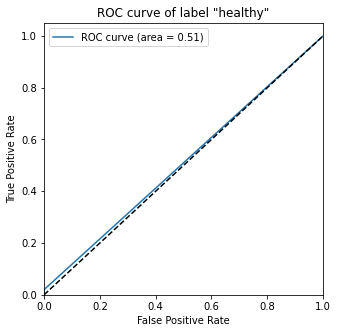

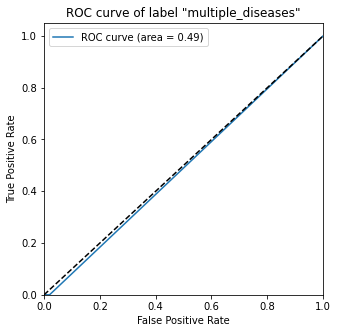

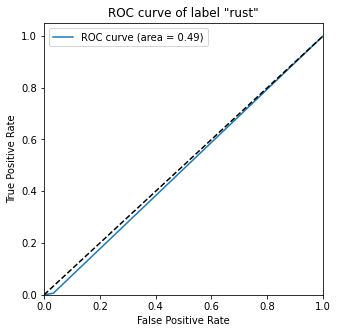

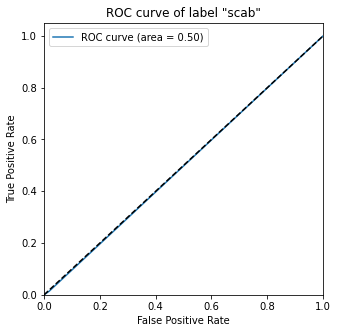

In [73]:
plt.rcParams['figure.figsize'] = [5, 5]

for i in range(4):
    plt.figure()
    plt.plot(fpr[keys[i]], tpr[keys[i]], label='ROC curve (area = %0.2f)' % auc_score[keys[i]])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('''ROC curve of label "%s"''' %keys[i])
    plt.legend(loc="best")
    plt.show()

# plt.plot([0, 1], [0, 1], 'k--')
# plt.plot(fpr, tpr, label='DT_matrix')
# plt.xlabel('False positive rate')
# plt.ylabel('True positive rate')
# plt.title('ROC curve - Earn & DT_matrix')
# plt.legend(loc='best')

# plt.rcParams['figure.figsize'] = [5, 5]

# plt.plot([0.0, 1.05],[0.0, 1.0], 'k--')
# plt.plot(recall, precision)
# plt.xlabel('Recall')
# plt.ylabel('Precision')
# plt.title("PR curve - Earn & DT_matrix")
# plt.show()